# Total Wet-Day Rainfall


```{glue:figure} accum_rain
:scale: 60%
:align: center
```

**Figure. Annual total rainfall anomalies relative to 1961–1990 climatology at Koror.** Units are mm/year.  The colored dots represent the 10 warmest years on record, with the absolute values shown along the right axis.    The dashed black line represents a trend that is not statistically significant.

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [ ]:
import warnings

warnings.filterwarnings("ignore")
import os.path as op
import sys

from myst_nb import glue

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import GHCN

from data_downloaders import GHCN, download_oni_index
from ind_setup.plotting_int import plot_oni_index_th
from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat
import df2img

In [ ]:
country = "Palau"
vars_interest = ["PRCP"]

### Get Data

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [ ]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f"The GHCN code for {country} is {df_country['Code'].values[0]}")

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[
        df_stations["ID"].str.startswith(df_country.Code.values[0])
    ]
    print(f"There are {df_country_stations.shape[0]} stations in {country}")

### Obervations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

In [ ]:
if update_data:
    GHCND_dir = "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/"
    id = "PSW00040309"  # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(
        GHCND_dir, "PRCP", df_country_stations.loc[df_country_stations["ID"] == id]
    )[0]
    data = dict_prcp[0]["data"]  # .dropna()
    data.to_pickle(op.join(path_data, "GHCN_precipitation.pkl"))
else:
    data = pd.read_pickle(op.join(path_data, "GHCN_precipitation.pkl"))

In [6]:
data.dropna(inplace=True)

## Analysis

### Plotting

Plotting raw data at daily scale

In [ ]:
dict_prcp = [{"data": data, "var": "PRCP", "ax": 1, "label": "Daily precipitation"}]
fig, trend_da_mean = plot_timeseries_interactive(
    dict_prcp,
    trendline=True,
    figsize=(25, 12),
    label_yaxes="Precipitation [mm]",
    return_trend=True,
)

#### Annual daily maxima

The evolution of the annual maximum precipitation is shown in the following plot.

In [ ]:
data_max = data.groupby(data.index.year).max()
data_max.index = pd.to_datetime(data_max.index, format="%Y")

dict_plot = [
    {"data": data_max, "var": "PRCP", "ax": 1, "label": "Annual daily maxima"},
]
plot_timeseries_interactive(
    dict_plot, trendline=True, figsize=(25, 12), label_yaxes="Precipitation [mm]"
);

#### Accumulated precipitation

The following plot analyzes the accumulated precipitation for each year since 1951.

In [ ]:
# Correct accumulated precipitation with number of observations per year to make fair comparisons and trends
datag = (
    data.groupby(data.index.year).sum() / data.groupby(data.index.year).count()
) * 365
datag.index = pd.to_datetime(datag.index, format="%Y")
dict_plot = [
    {"data": datag, "var": "PRCP", "ax": 1, "label": "Accumulated precipitation [mm]"},
]

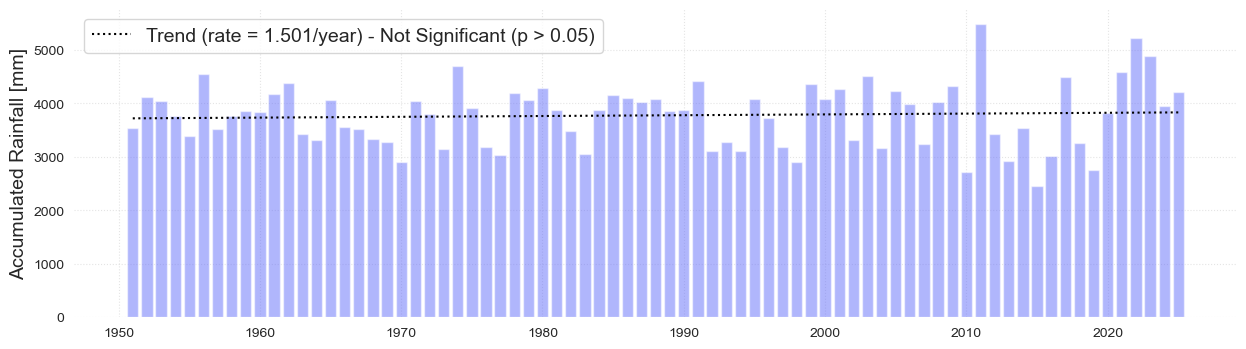

In [ ]:
fig, ax, trend_ac_an = plot_bar_probs(
    x=datag.index.year,
    y=datag["PRCP"].values,
    trendline=True,
    figsize=[15, 4],
    return_trend=True,
)
ax.set_ylabel("Accumulated Rainfall [mm]", fontsize=fontsize)
glue("accum_rain", fig, display=False)


In [ ]:
nevents = 10  # Top n events to extract
datag["PRCP_ref"] = datag["PRCP"].values - datag.loc["1961":"1990"].PRCP.mean()
top_10 = datag.sort_values(by="PRCP_ref", ascending=False).head(nevents)

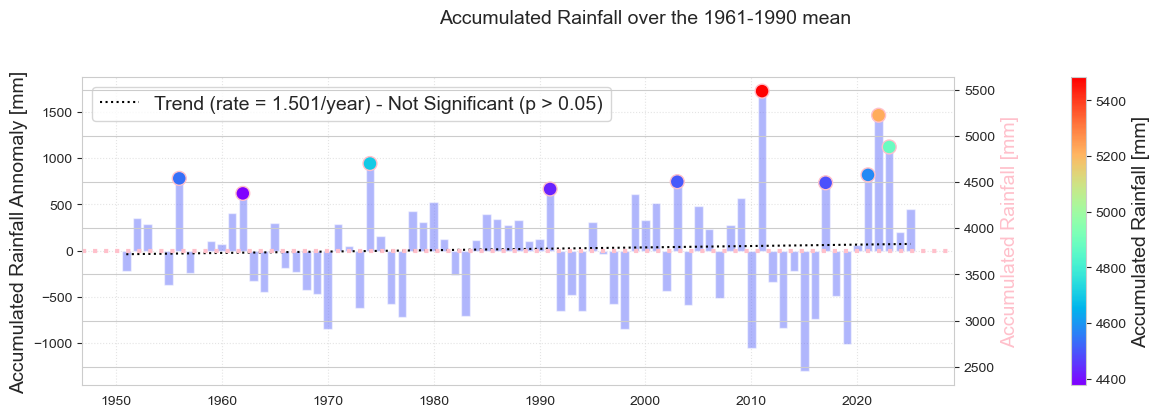

In [ ]:
prcp_an = datag["PRCP"].values - datag.loc["1961":"1990"].PRCP.mean()
fig, ax = plot_bar_probs(x=datag.index.year, y=prcp_an, trendline=True, figsize=[15, 4])
ax.set_ylim(np.nanmin(prcp_an) - 150, np.nanmax(prcp_an) + 150)
ax.set_ylabel("Accumulated Rainfall Annomaly [mm]", fontsize=fontsize)
ax2 = ax.twinx()
ax2.axhline(
    datag.loc["1961":"1990"].PRCP.mean(), color="pink", linestyle=":", linewidth=3
)
ax2.set_ylim(
    np.nanmin(prcp_an) - 150 + datag.loc["1961":"1990"].PRCP.mean(),
    np.nanmax(prcp_an) + 150 + datag.loc["1961":"1990"].PRCP.mean(),
)
ax2.set_ylabel("Accumulated Rainfall [mm]", fontsize=fontsize, color="pink")

im = ax2.scatter(
    top_10.index.year,
    top_10.PRCP,
    c=top_10.PRCP.values,
    s=100,
    ec="pink",
    cmap="rainbow",
    label="Top 10 warmest years",
)

plt.colorbar(im, pad=0.1).set_label("Accumulated Rainfall [mm]", fontsize=fontsize)
fig.suptitle("Accumulated Rainfall over the 1961-1990 mean", fontsize=fontsize, y=1.05)
plt.savefig(op.join(path_figs, "F5_Rain_anom_top10.png"), dpi=300, bbox_inches="tight")
glue("accum_rain", fig, display=False)


### Accumulated rainfall per season

Dry Season - December to April

Wet Season - May to October

In [ ]:
data.loc[(data.index.month >= 5) & (data.index.month < 11), "season"] = "wet"
data.loc[(data.index.month < 5) | (data.index.month >= 11), "season"] = "dry"

In [ ]:
data_dry = data.loc[data.season == "dry"].drop("season", axis=1)
datag_dry = (
    data_dry.groupby(data_dry.index.year).sum()
    / data_dry.groupby(data_dry.index.year).count()
) * 365
datag_dry.index = pd.to_datetime(datag_dry.index, format="%Y")

Text(0.5, 1.05, 'Accumulated Rainfall DRY SEASON over the 1961-1990 mean')

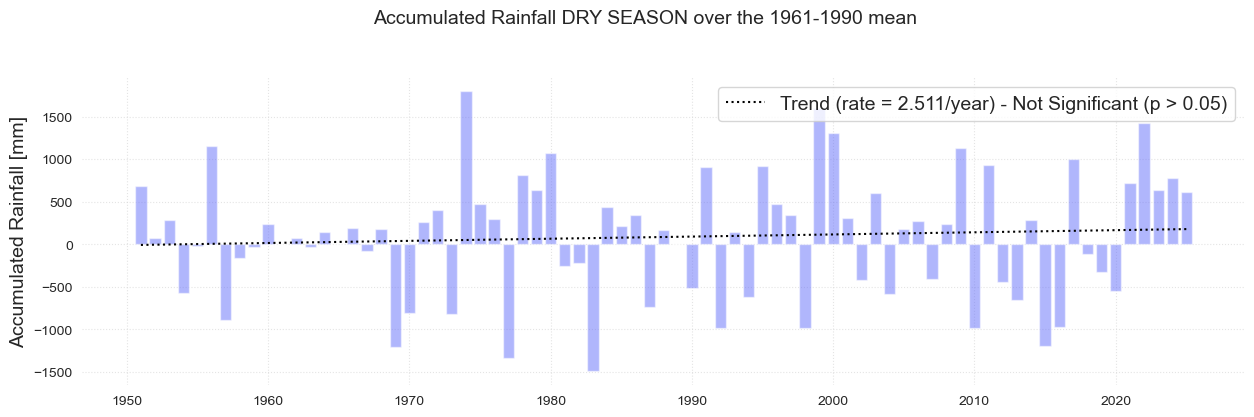

In [ ]:
fig, ax = plot_bar_probs(
    x=datag_dry.index.year,
    y=datag_dry["PRCP"].values - datag_dry.loc["1961":"1990"].PRCP.mean(),
    trendline=True,
    figsize=[15, 4],
)
ax.set_ylabel("Accumulated Rainfall [mm]", fontsize=fontsize)
fig.suptitle(
    "Accumulated Rainfall DRY SEASON over the 1961-1990 mean", fontsize=fontsize, y=1.05
)


In [ ]:
data_wet = data.loc[data.season == "wet"].drop("season", axis=1)
datag_wet = (
    data_wet.groupby(data_wet.index.year).sum()
    / data_wet.groupby(data_wet.index.year).count()
) * 365
datag_wet.index = pd.to_datetime(datag_wet.index, format="%Y")

Text(0.5, 1.05, 'Accumulated Rainfall WET SEASON over the 1961-1990 mean')

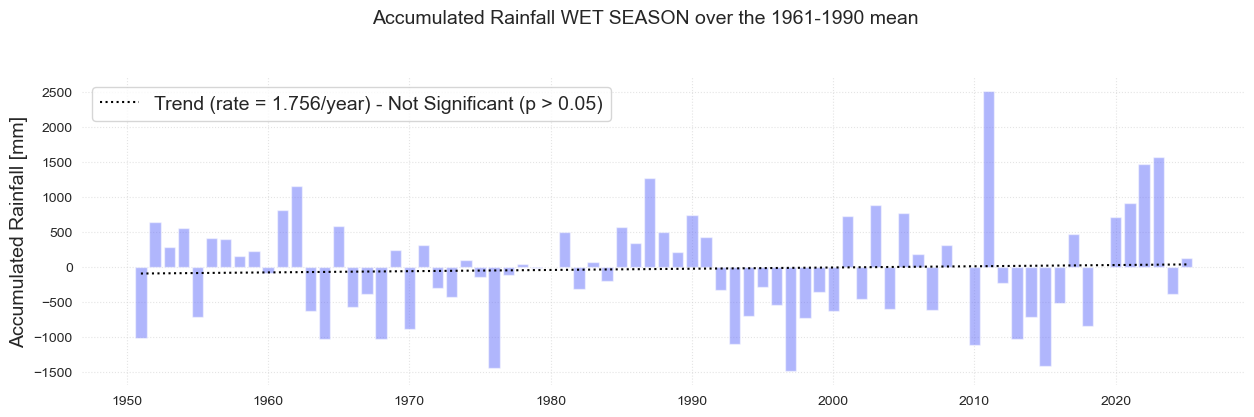

In [ ]:
fig, ax = plot_bar_probs(
    x=datag_wet.index.year,
    y=datag_wet["PRCP"].values - datag_wet.loc["1961":"1990"].PRCP.mean(),
    trendline=True,
    figsize=[15, 4],
)
ax.set_ylabel("Accumulated Rainfall [mm]", fontsize=fontsize)
fig.suptitle(
    "Accumulated Rainfall WET SEASON over the 1961-1990 mean", fontsize=fontsize, y=1.05
)


## ONI index

The Oceanic Niño Index (ONI) is the standard measure used to monitor El Niño and La Niña events. It is based on sea surface temperature anomalies in the central equatorial Pacific (Niño 3.4 region) averaged over 3-month periods. 

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [ ]:
p_data = "https://psl.noaa.gov/data/correlation/oni.data"

In [ ]:
if update_data:
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, "oni_index.pkl"))
else:
    df1 = pd.read_pickle(op.join(path_data, "oni_index.pkl"))

In [ ]:
lims = [-0.5, 0.5]
plot_oni_index_th(df1, lims=lims)

### Analysis

In [ ]:
st_data = data
st_data_monthly = st_data.drop("season", axis=1).resample("M").mean()
st_data_monthly.index = pd.DatetimeIndex(st_data_monthly.index).to_period(
    "M"
).to_timestamp() + pd.offsets.MonthBegin(1)

In [ ]:
df1["prcp"] = st_data_monthly["PRCP"]  # .rolling(window=rolling_mean).mean()

In [ ]:
df1 = add_oni_cat(df1, lims=lims)

#### Plotting

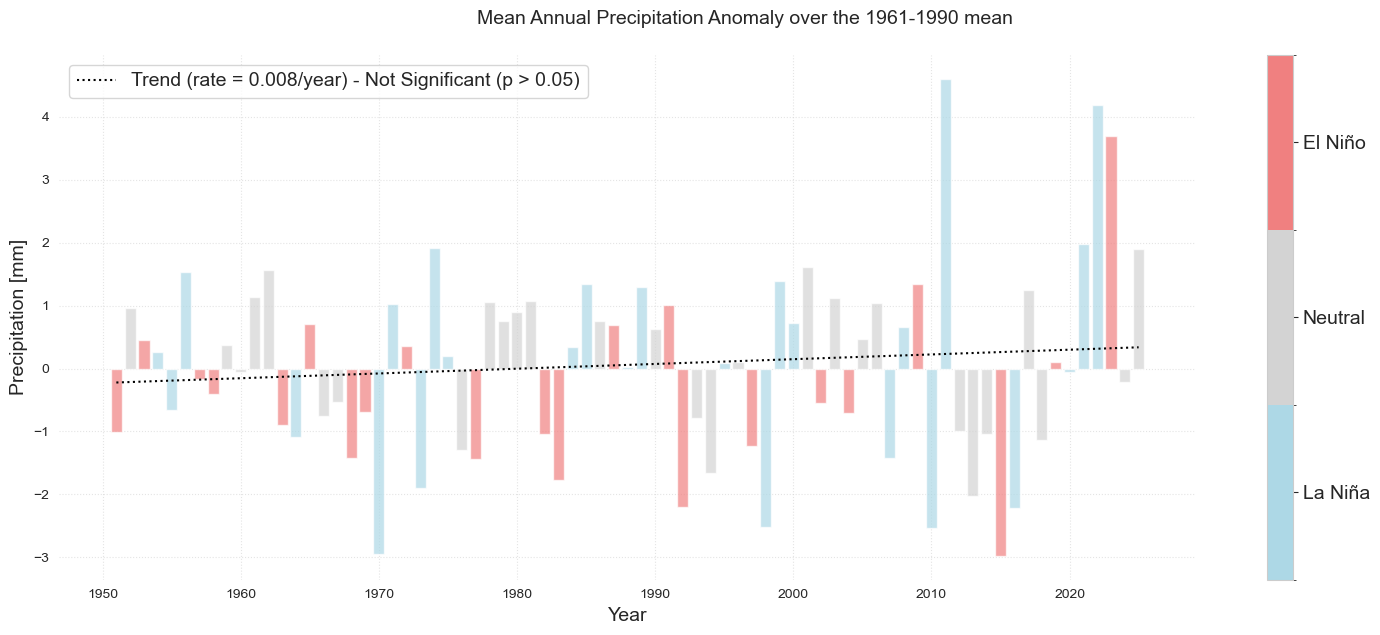

In [ ]:
df2 = df1.resample("Y").mean()
df2["prcp_ref"] = df2.prcp - df2.loc["1961":"1990"].prcp.mean()
fig = plot_bar_probs_ONI(df2, var="prcp_ref", y_label="Precipitation [mm]")
fig.suptitle(
    "Mean Annual Precipitation Anomaly over the 1961-1990 mean",
    fontsize=fontsize,
    y=1.05,
)
plt.savefig(op.join(path_figs, "F5_Rain_mean.png"), dpi=300, bbox_inches="tight")


In [25]:
df_format = np.round(df1.describe(), 2)

### Table
Table sumarizing different metrics of the data analyzed in the plots above

In [26]:
from ind_setup.tables import style_matrix, table_rain_21

In [ ]:
style_matrix(
    table_rain_21(data, trend_da_mean, trend_ac_an),
    title="Mean Precipitation Metrics and Trends",
)

Metric,Value
Daily Precipitation Mean (mm),10.359
Change in Daily Precipitation since 1960 (mm),118.625
Rate of Change in Daily Precipitation (mm/year),0.005
,
Mean Accumulated Annual Precipitation (mm),3774.175
Change in Accumulated Annual Precipitation since 1960 (mm),97.565
Rate of Change in Accumulated Annual Precipitation (mm/year),1.501
